# Music Information Retrieval - Notebook



In [2]:
import numpy as np
from matplotlib import pyplot as plt
import IPython.display as ipd
import soundfile as sf
import sounddevice as sd
from time import sleep
import scipy.io.wavfile
import librosa
import ipywidgets as widgets
import pyaudio
import threading
import wave

from ipynb.fs.defs.fourier import fourier_transform, plot_fourier, find_pitches
from ipynb.fs.defs.record import record
from ipynb.fs.full.chords import dictionary_tones, dictionary_chords

## Synthetisierung

Hiermit können Töne mit bestimmter Frequenz und Amplitude synthetisiert werden. Die Wellen der Töne werden als Array dargestellt, dabei gibt sr die Samplingrate an (Standard 44100 Hertz). Werden mehrere Wellen addiert, entstehen Akkorde. Mithilfe 'librosa.note_to-hz' kann die Tonhöhe in die Frequenz umgewandelt werden. Beispielsweise ergeben die Töne C4, E4, G4 einen C-Dur-Akkord.

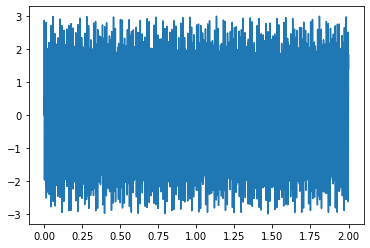

In [111]:
sr = 44100 # in Hertz
duration = 2 # in Sekunden

def generate_wave(frequency=None, amplitude=1):
    if frequency is None:
        return
    else:
        global x
        x = np.linspace(0, duration, sr * duration, endpoint=False)
        frequencies = x * frequency
        wave = np.sin((2 * np.pi) * frequencies) * amplitude  
        return wave

wave1 = generate_wave(librosa.note_to_hz('C4'))
wave2 = generate_wave(librosa.note_to_hz('E4'))
wave3 = generate_wave(librosa.note_to_hz('G#4'))
#wave4 = generate_wave(librosa.note_to_hz('A4'))
synthesized_wave = wave1 + wave2 + wave3 #+ wave4

plt.plot(x, synthesized_wave)
plt.show()
ipd.Audio(data=synthesized_wave, rate=sr)

## Aufnahme

Hier können Töne mit dem Mikrofon aufgenommen werden. Dabei kann bestimmt werden, mit welcher Samplingrate aufgenommen und unter welchem Filenamen die Aufnahme abgespeichert wird. Außerdem kann durch die Variable 'detect_onsets' bestimmt werden, ob in der Aufnahme automatisch Onsets erkannt werden sollen. Wird dieser Block ausgeführt, erscheint ein Button, durch den die Aufnahme gestartet werden kann. Wird der Button erneut gedrückt, wird die Aufnahme gestoppt, in eine WAV-Datei überführt, geplottet und zum Abspielen bereitgestellt. 

In [3]:
sr = 44100 # Samplingrate in Hertz
file = 'recording.wav' # Name der WAV-Datei
detect_onsets = False # gibt an, ob in der Aufnahme Onsets erkannt werden sollen
timer = 1 # Sekunden zwischen Klick auf den Button und Start der Aufnahme 


record(sr, file, detect_onsets, timer)

Button(description='record', icon='microphone', style=ButtonStyle())

recording...


## Erkennen der Tonhöhe
Fourier-Transformation:

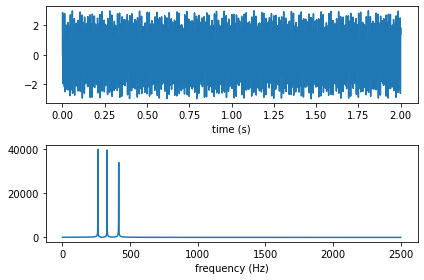

Tonhoehe1: 261.5 Hertz
Ton1: C4
Tonhoehe2: 329.5 Hertz
Ton2: E4
Tonhoehe3: 415.5 Hertz
Ton3: G♯4


In [112]:
# recording, sr = sf.read('recording.wav')
recording = synthesized_wave
# def fourier_tronsform(wave, sr=44100)
x_fourier, y_fourier = fourier_transform(recording)

# def plot_fourier(wave, x_fourier, y_fourier, sr=44100)
plot_fourier(recording, x_fourier, y_fourier)

# def find_pitches(wave, y_fourier, sr=44100)
tones = find_pitches(recording, y_fourier)


## Akkorderkennung

Hier kann anhand von Tönen, die vorher mit der Fourier-Transformation gefunden wurden, ein Akkord erkannt werden. Das Programm erkennt Akkorde mit drei Tönen, nämlich Dur- (maj), Moll- (min), verminderte (dim) und übermäßge (aug) Akkorde. 

In [113]:
octave = [0,0,0,0,0,0,0,0,0,0,0,0]

for i in tones:
    i = i.rstrip(i[-1])
    try:
        octave[dictionary_tones[i]] = 1
    except(KeyError): 
        i = i.rstrip(i[-1])
        i = i + '#'
        octave[dictionary_tones[i]] = 1
        
print(octave)

try:
    print("Akkord: ", list(dictionary_chords.keys())[list(dictionary_chords.values()).index(octave)])
except(ValueError):
    print("No chord found")

[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Akkord:  Caug/Eaug/G#aug


## Onset detection

Dieser Abschnitt besteht zusätzlich zur Akkorderkennung. Hier können mit Hilfe von der Bibliothek Librosa Onsets erkannt werden. Diese Onsets werden in der Ausgabe der Aufnahme durch rote Linien markiert. Außerdem kann die Aufnahme erneut abgespielt werden, dabei sind die erkannten Onsets durch Klicks erkennbar.

Anzahl der der Schläge: 8


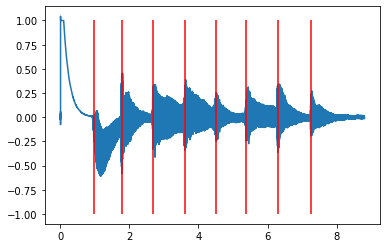

In [9]:
sr = 44100


x, sr = librosa.load('recording.wav')
onset_frames = librosa.onset.onset_detect(y=x, sr=sr, wait=1, pre_avg=1, post_avg=1, pre_max=1, post_max=1)
# print(onset_frames)
print("Anzahl der der Schläge:", len(onset_frames))
onset_times = librosa.frames_to_time(onset_frames)
# print(onset_times)
clicks = librosa.clicks(frames=onset_frames, sr=sr, length=len(x))

# plot:
    
time = [None] * len(x)
for i in range(len(x)):
    time[i] = i / sr
    
plt.plot(time, x)
plt.vlines(onset_times, -1, 1, color='r')
plt.show

# Audio

ipd.Audio(x + clicks, rate=sr)